#### Import required libraries  

In [33]:
import rasterio  
from rasterio.plot import show  
from rasterio.transform import Affine  
from skimage.exposure import match_histograms  
from skimage.metrics import structural_similarity as ssim  
from skimage.metrics import normalized_mutual_information  
from skimage.transform import resize, pyramid_reduce  
from scipy.ndimage import shift  
import numpy as np 
import matplotlib.pyplot as plt  
from scipy.optimize import minimize  
from joblib import Parallel, delayed  

#### Load bands

In [34]:
def load_band(file_path):
    """
    Load a single spectral band from a GeoTIFF file.
    
    Parameters:
        file_path (str): Path to the image file.
    
    Returns:
        band (ndarray): 2D array representing the spectral band.
        profile (dict): Metadata of the raster file (georeferencing, resolution, etc.).
    """
    with rasterio.open(file_path) as src:
        band = src.read(1)  # Read the first band (single band image)
        profile = src.profile  # get metadata
    return band, profile

#### resize the bands

In [35]:
def resample_band(band, target_shape):
    """
    Resizes a band to match the target shape.

    Parameters:
        band (ndarray): The image band to be resized.
        target_shape (tuple): The desired shape (height, width).

    Returns:
        ndarray: The resized band.
    """
    return resize(band, target_shape, mode='reflect', preserve_range=True).astype(band.dtype)

#### Normalize bands

In [36]:
def normalize_percentile (band, lower_percentile=2, upper_percentile=98):
    """
    Normalizes pixel intensities using percentile-based contrast stretching.

    Parameters:
        band (ndarray): The image band to be normalized.
        lower_percentile (int): The lower percentile threshold.
        upper_percentile (int): The upper percentile threshold.

    Returns:
        ndarray: Normalized band with values scaled between 0 and 1.
    """
    lower = np.percentile(band, lower_percentile)
    upper = np.percentile(band, upper_percentile)
    band = np.clip(band, lower, upper)  # Clip pixel values within the range
    return (band - lower) / (upper - lower)  # Normalize between 0 and 1

#### Align bands

In [37]:
def align_band_intensity_based(reference, target, downsample_factor=4):
    """
    Aligns a spectral band to a reference band using intensity-based mutual information.

    Parameters:
        reference (ndarray): The reference band (e.g., RGB band).
        target (ndarray): The band to be aligned.
        downsample_factor (int): Factor for reducing image resolution to speed up alignment.

    Returns:
        ndarray: The aligned band.
    """
    # Downsample images to reduce computation time
    reference_ds = pyramid_reduce(reference, downsample_factor)
    target_ds = pyramid_reduce(target, downsample_factor)

    def mutual_information_cost(params):
        tx, ty = params  # Translation shift parameters (x, y)
        shifted_target = shift(target_ds, (ty, tx))  #Shift the target image by (tx, ty)
        return -normalized_mutual_information(reference_ds, shifted_target)  # Minimize negative mutual information
#Normalized mutual information (NMI) measures the similarity between two images by evaluating their shared information, higher the values better the alignment and greater similarity in intensity distributions.
#We use the negative value for NMI because optimization algorithms(below this sentence) typically minimize functions. By minimizing the negative mutual information, we effectively maximize the actual mutual information, improving image alignment.    
    # Optimize the shift parameters using Powell's method
    result = minimize(mutual_information_cost, [0, 0], method='Powell', options={'maxiter': 10})
    # Scale the shifts back to the original resolution by multiplying with downsample_factor
    tx, ty = result.x
    tx *= downsample_factor 
    ty *= downsample_factor

    # Apply the final computed shift
    return shift(target, (ty, tx))


##### Match Histogram

In [38]:
def match_histogram(band, reference):
    """
    Adjusts the intensity distribution of the input band to match the reference band.

    Parameters:
        band (ndarray): The band to be adjusted.
        reference (ndarray): The reference band.

    Returns:
        ndarray: Histogram-matched band.
    """
    return match_histograms(band, reference)


In [39]:
def save_coregistered(output_path, bands, profile):
    """
    Saves the coregistered bands into a single GeoTIFF file.

    Parameters:
        output_path (str): Path where the output file will be saved.
        bands (list of ndarray): List of coregistered bands.
        profile (dict): Metadata for geospatial information.
    """
    # Update metadata profile for multi-band output
    profile.update({
        'count': len(bands),
        'dtype': 'float32', 
        'compress': 'lzw',  
        'height': bands[0].shape[0],  
        'width': bands[0].shape[1],  
        'nodata': 0, 
        'transform': Affine(1.0, 0.0, 0.0, 0.0, 1.0, 0.0),  # Identity transformation
#The 'transform' parameter defines how the image is positioned in a spatial reference system.
#Affine(1.0, 0.0, 0.0, 0.0, 1.0, 0.0) represents an identity transformation, meaning:
#Scale (1.0, 1.0): No scaling, each pixel corresponds directly to its original size.
#Shear (0.0, 0.0): No skewing, meaning the image remains rectangular.
#Translation (0.0, 0.0): No shift, so the origin remains unchanged.
        'crs': "EPSG:4326", 
    })   
    # Write to GeoTIFF file
    with rasterio.open(output_path, 'w', **profile) as dst:
        for i, band in enumerate(bands, 1):  # Since bands are indexed from 1 in rasterio
            dst.write(band, i)

In [40]:
print("Loading and processing bands...")
gre_band, profile = load_band('Bands Image Data/IMG_700101_000529_0000_GRE.TIF')
reg_band, _ = load_band('Bands Image Data/IMG_700101_000529_0000_NIR.TIF')
nir_band, _ = load_band('Bands Image Data/IMG_700101_000529_0000_RED.TIF')
red_band, _ = load_band('Bands Image Data/IMG_700101_000529_0000_REG.TIF')
# Reference band
rgb_band, _ = load_band('Bands Image Data/IMG_700101_000530_0000_RGB.JPG')

# resize the bands
target_shape = rgb_band.shape
gre_band = resample_band(gre_band, target_shape)
reg_band = resample_band(reg_band, target_shape)
nir_band = resample_band(nir_band, target_shape)
red_band = resample_band(red_band, target_shape)

# Normalize the bands
gre_band = normalize_percentile(gre_band)
reg_band = normalize_percentile(reg_band)
nir_band = normalize_percentile(nir_band)
red_band = normalize_percentile(red_band)
rgb_band = normalize_percentile(rgb_band)

print("Performing coregistration...")

bands_to_align = [gre_band, reg_band, nir_band, red_band]

# Parallel processing for faster alignment and histogram matching
aligned_bands = Parallel(n_jobs=-1)(
    delayed(lambda b: match_histogram(align_band_intensity_based(rgb_band, b), rgb_band))(band) 
    for band in bands_to_align
)
#Parallel from joblib enables multi-core processing, meaning multiple bands can be processed simultaneously instead of one by one-->for faster alignment.
#n_jobs=-1 tells it to use all available CPU cores for maximum speed.
coregistered_bands = aligned_bands + [rgb_band]
#saving the final corestered image in a geotif file
save_coregistered('coregistered_image.tif', coregistered_bands, profile)
print("Coregistration completed successfully!")

Loading and processing bands...
Performing coregistration...
Coregistration completed successfully!


#### Visualize bands

In [41]:
def visualize_bands(bands, titles, cols=3, figsize=(15, 10)):
    """
    Displays multiple image bands in a grid format.

    Parameters:
        bands (list of ndarrays): List of image bands to display.
        titles (list of str): Titles for each image.
        cols (int): Number of columns in the grid (default is 3).
        figsize (tuple): Size of the entire figure (default is (15,10)).

    Returns:
        None (Displays the images)
    """
    rows = int(np.ceil(len(bands) / cols))
    plt.figure(figsize=figsize)
    
    # Loop through each band and displays it
    for i, (band, title) in enumerate(zip(bands, titles), 1):
        plt.subplot(rows, cols, i)
        plt.imshow(band, cmap='gray', vmin=0, vmax=1)  # grayscale image (normalized)
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

#### Visualizing the original bands i.e, before coregistration

Original Bands:


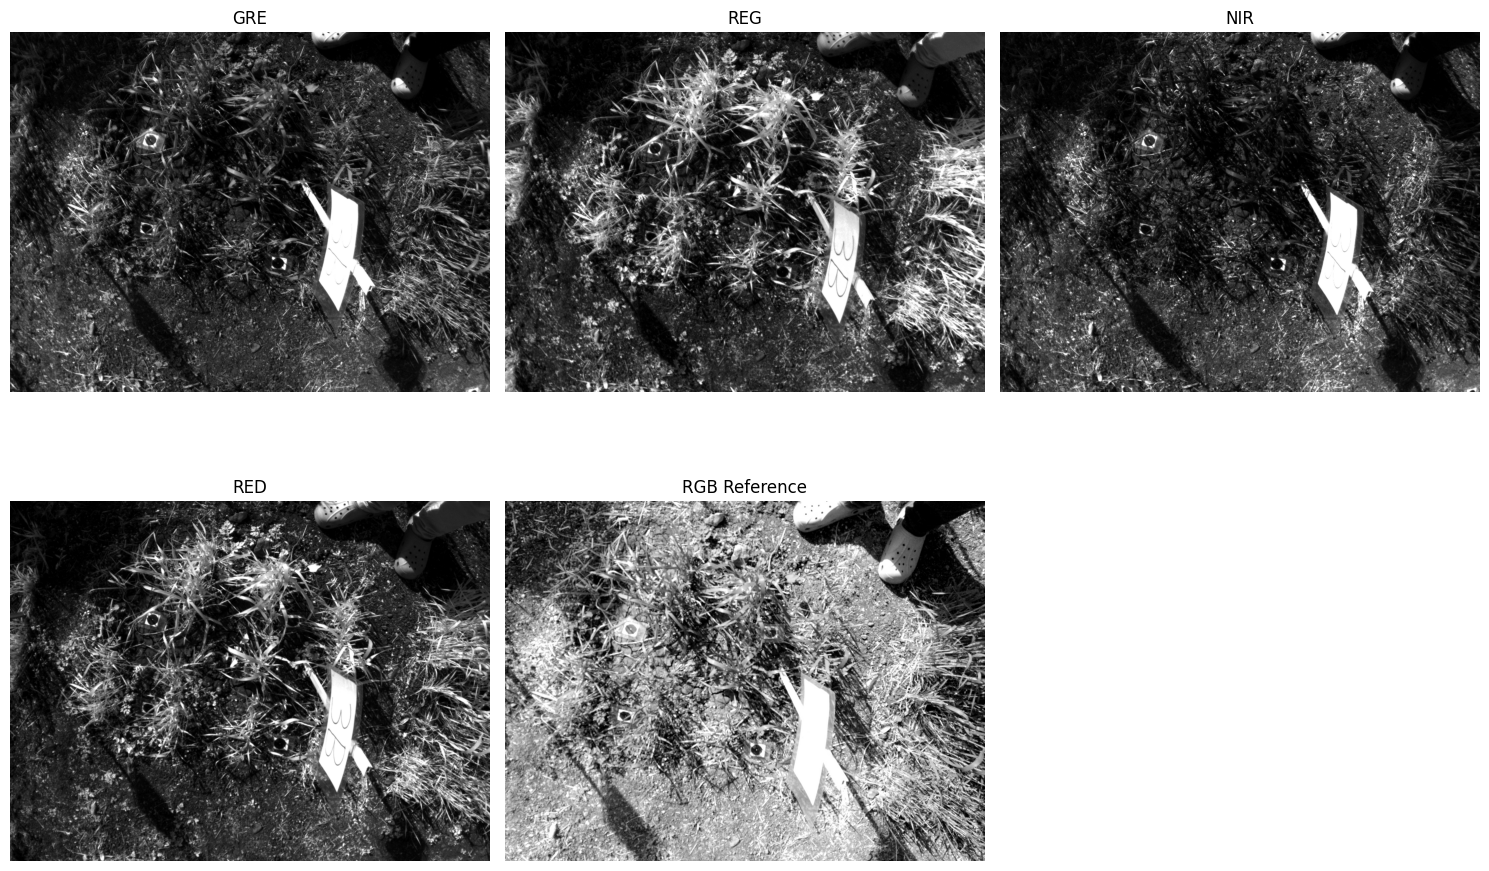

In [42]:
print("Original Bands:")
visualize_bands(
    [gre_band, reg_band, nir_band, red_band, rgb_band],
    ['GRE', 'REG', 'NIR', 'RED', 'RGB Reference'],
    cols=3 
)

#### Visualizing the Aligned Bands

Aligned Bands:


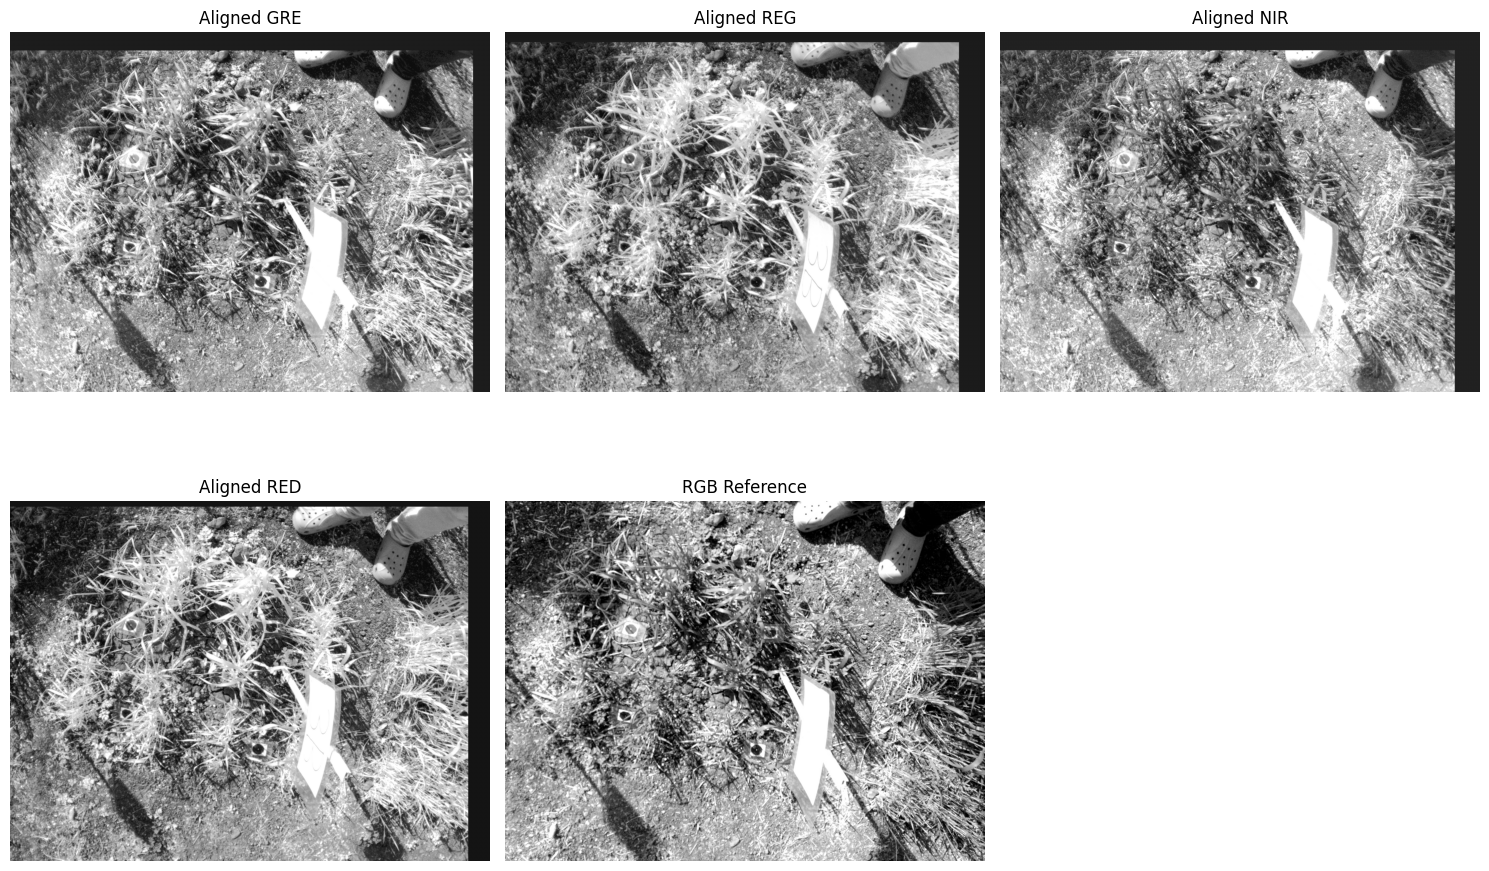

In [43]:
print("Aligned Bands:")
visualize_bands(
    aligned_bands + [rgb_band],
    ['Aligned GRE', 'Aligned REG', 'Aligned NIR', 'Aligned RED', 'RGB Reference'],
    cols=3
)


In [44]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

def compute_rmse(reference, aligned):
    """
    Computes the Root Mean Square Error (RMSE) between two images.

    Parameters:
        reference (ndarray): The reference image (e.g., RGB band(Here).
        aligned (ndarray): The aligned image (e.g., a spectral band after coregistration).

    Returns:
        float: RMSE value, representing the pixel-wise error between the images.
    """
    return np.sqrt(np.mean((reference - aligned) ** 2)) 
print("\nComputing alignment metrics...")  
print(f"{'Band':<10} {'RMSE':<15} {'SSIM':<15}")


# Iterate through each aligned band and compute metrics
for band, name in zip(aligned_bands, ['GRE', 'REG', 'NIR', 'RED']):
    rmse = compute_rmse(rgb_band, band)  # Compute RMSE between the reference RGB band and the aligned band
    ssim_val = ssim(rgb_band, band, data_range=1.0)  # Compute Structural Similarity Index (SSIM)

    # Print the results for each band with proper formatting
    print(f"{name:<10} {rmse:<15.4f} {ssim_val:<15.4f}")



Computing alignment metrics...
Band       RMSE            SSIM           
GRE        0.2789          0.1918         
REG        0.2975          0.2062         
NIR        0.2670          0.2005         
RED        0.3004          0.1814         
